### 1.A. 畫圖

In [1]:
import pandas as pd
import IPython
import numpy as np
from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 移除警告語，視覺上比較乾淨
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
net = Network()
net.add_nodes(["Chicago", "Washington", "Dallas", "New York",
               "Detorit", "Seattle", "Denver", "Cincinnati", "Miami"])
net.add_edges([("Chicago", "Washington")
,("Washington", "Dallas")
,("Chicago", "New York")
,("New York", "Detorit")
,("Detorit", "Dallas")
,("Detorit", "Seattle")
,("Dallas", "Seattle")
,("Detorit", "Denver")
,("Detorit", "Cincinnati")
,("Denver", "Miami")
,("Cincinnati", "Miami")
,("Denver", "Cincinnati")])

net.show('./demo.html')
# colab可以解開直接看
IPython.display.HTML('./demo.html')

In [4]:
# Create network plot 
G = nx.Graph()

edges = [("Chicago", "Washington"),
         ("Chicago", "New York"),
         ("Washington", "Dallas"),
         ("New York", "Detorit"),
         ("Detorit", "Dallas"),
         ("Detorit", "Seattle"),
         ("Dallas", "Seattle"),
         ("Detorit", "Denver"),
         ("Detorit", "Cincinnati"),
         ("Denver", "Miami"),
         ("Cincinnati", "Miami"),
         ("Denver", "Cincinnati")]

for x,y in edges:
    G.add_edge(x, y)

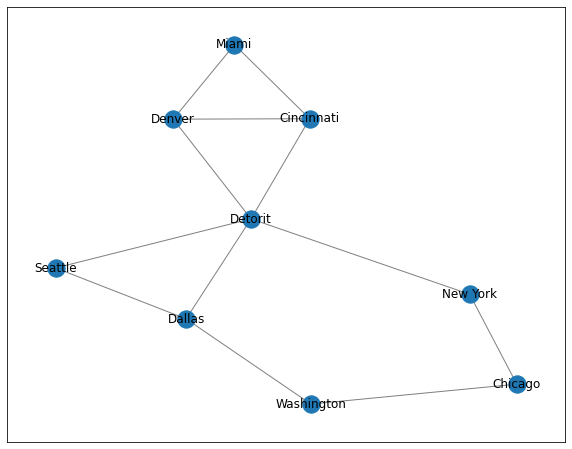

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
    
# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, scale=len(G.nodes()))
# pos = nx.random_layout(G)

# networks
nx.draw_networkx(G, pos,
                 edge_color='grey',
                 with_labels = True,
                 ax=ax)

plt.show()

### 1.B 計算圖形

In [6]:
# Density
nx.density(G)

0.3333333333333333

In [7]:
# Distance
nx.average_shortest_path_length(G)

2.0

In [8]:
# Diameter
nx.diameter(G)

4

In [9]:
# clustering coefficient
nx.average_clustering(G)

0.4296296296296296

### 2.A LDA（K=4）

In [10]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

In [11]:
# 設定圖的字體大小
font = {'size':14}
matplotlib.rc('font', **font)

In [12]:
# 匯入資料
metadata = pd.read_csv('./News2.csv', encoding='UTF-8')

In [13]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
jieba.set_dictionary('./dict/dict.txt') 

# 自定義辭典
print("--> 匯入自定義字典，這裡匯入疫苗的名稱")
jieba.load_userdict('./dict/user_dict.txt')

Building prefix dict from /Users/beemo/Documents/中山/二上/社群媒體/final/dict/dict.txt ...


--> 匯入自定義字典，這裡匯入疫苗的名稱


Dumping model to file cache /var/folders/pb/7gdg5h6n4y3_8g14d0151y9w0000gn/T/jieba.u452bae8558d79866e1e581e434745ee3.cache
Loading model cost 0.327 seconds.
Prefix dict has been built successfully.


In [14]:
# 資料進行斷詞，為list的格式
data = metadata[['article_content']]
token_df = data.assign(wordlist = data['article_content'].apply(jieba.lcut))

print("資料斷詞後的 DataFrame：article_content(文章)、wordlist(斷詞)")
token_df.head(3)

資料斷詞後的 DataFrame：article_content(文章)、wordlist(斷詞)


,article_content,wordlist
0,最後就剩李政宰獲勝\n\n其餘全部死光\n\n爽拿所有獎金\n\n然後一開始有腦癌的老頭居然...,"[最後, 就, 剩, 李政宰, 獲勝, \n, \n, 其餘, 全部, 死光, \n, \n..."
1,最近看魷魚遊戲\n\n日本的大逃殺、好萊塢的飢餓遊戲直接被海放\n\n為什麼韓國拍得出這麼獵...,"[最近, 看, 魷魚, 遊戲, \n, \n, 日本, 的, 大逃殺, 、, 好萊塢, 的,..."
2,魷魚遊戲我覺得算前面還好\n後面有比較好看\n\n-防雷-\n\n\n\n\n\n\n\n\...,"[魷魚, 遊戲, 我, 覺得, 算, 前面, 還好, \n, 後面, 有, 比較, 好看, ..."


In [15]:
stopwords = []

#匯入檔案
with open(f'./dict/stopwords.txt','r') as f:
    stopwords = f.read().splitlines() #移除換行符號\n

print("stropwords儲存為list形式，前幾個為：")
stopwords[:15]

stropwords儲存為list形式，前幾個為：


['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”']

In [16]:
# 移除停用字的 function
def remove_stop(listt):
    result = [re.sub(r'\d|-', '', word) for word in listt]
    result = [word for word in result if len(word)>1] 
    result = list(filter(lambda x : x not in stopwords, result)) 
    return result

In [17]:
# list 刪掉 stopwords
token_df = token_df.assign( remove_stopwords = token_df['wordlist'].apply(remove_stop))
print("remove_stopwords 為 wordlist 移除停用字後的結果：")
token_df.head(3)

remove_stopwords 為 wordlist 移除停用字後的結果：


,article_content,wordlist,remove_stopwords
0,最後就剩李政宰獲勝\n\n其餘全部死光\n\n爽拿所有獎金\n\n然後一開始有腦癌的老頭居然...,"[最後, 就, 剩, 李政宰, 獲勝, \n, \n, 其餘, 全部, 死光, \n, \n...","[最後, 李政宰, 獲勝, 死光, 獎金, 腦癌, 老頭, 主辦, 方之一, 待在, 觀眾席..."
1,最近看魷魚遊戲\n\n日本的大逃殺、好萊塢的飢餓遊戲直接被海放\n\n為什麼韓國拍得出這麼獵...,"[最近, 看, 魷魚, 遊戲, \n, \n, 日本, 的, 大逃殺, 、, 好萊塢, 的,...","[最近, 魷魚, 遊戲, 日本, 大逃殺, 好萊塢, 飢餓, 遊戲, 直接, 海放, 韓國,..."
2,魷魚遊戲我覺得算前面還好\n後面有比較好看\n\n-防雷-\n\n\n\n\n\n\n\n\...,"[魷魚, 遊戲, 我, 覺得, 算, 前面, 還好, \n, 後面, 有, 比較, 好看, ...","[魷魚, 遊戲, 前面, 還好, 後面, 好看, 防雷, 最後, 第六天, 決勝, 比賽, ..."


In [18]:
token_data = token_df['remove_stopwords'].tolist()

In [19]:
for i in range(0,3):
    print("第 " + str(i+1) + " 篇文章前10個字：")
    for j in range(0,10):
        print(token_data[i][j], end=' ')
    print('\n')

第 1 篇文章前10個字：
最後 李政宰 獲勝 死光 獎金 腦癌 老頭 主辦 方之一 待在 

第 2 篇文章前10個字：
最近 魷魚 遊戲 日本 大逃殺 好萊塢 飢餓 遊戲 直接 海放 

第 3 篇文章前10個字：
魷魚 遊戲 前面 還好 後面 好看 防雷 最後 第六天 決勝 



In [20]:
id2word = corpora.Dictionary(token_data)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(18413 unique tokens: ['下去', '主辦', '哥哥', '待在', '方之一']...)


In [21]:
corpus = [id2word.doc2bow(text) for text in token_data]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


In [22]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [23]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, 
    id2word=id2word, # 字典
    num_topics=4, # 生成幾個主題數
    random_state=2021, # 亂數
    iterations = 1000,
    passes=5, # 模型訓練次數
)

In [24]:
# 每個主題重要的前10個關鍵字
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.008*"大樓" + 0.005*"高雄" + 0.005*"火災" + 0.005*"王力宏" + 0.005*"https" + 0.005*"台灣" + 0.004*"這種" + 0.004*"城中城" + 0.004*"消防" + 0.004*"新聞"')
(1, '0.011*"高雄" + 0.009*"救護車" + 0.009*"分隊" + 0.009*"醫院" + 0.008*"城中城" + 0.007*"https" + 0.007*"意識" + 0.007*"男性" + 0.006*"清醒" + 0.006*"新聞"')
(2, '0.012*"遊戲" + 0.007*"魷魚" + 0.004*"原文" + 0.003*"現在" + 0.003*"股價" + 0.003*"台股" + 0.003*"知道" + 0.003*"市值" + 0.003*"美元" + 0.003*"台灣"')
(3, '0.010*"遊戲" + 0.009*"宇宙" + 0.007*"王力宏" + 0.005*"魷魚" + 0.005*"原文" + 0.004*"宏達電" + 0.004*"https" + 0.004*"股價" + 0.003*"時間" + 0.003*"VR"')


### 2.B LDAvis

In [25]:
ldaVis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
pyLDAvis.save_html(ldaVis,'./lda_result/ldaVis.html')

/opt/homebrew/Caskroom/miniforge/base/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [26]:
IPython.display.HTML('./lda_result/ldaVis.html')

### 3. perplexity

In [27]:
PMI_model_lda = CoherenceModel(model=ldamodel, texts=token_data, coherence='c_uci')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

這個主題的 PMI score:  -4.283010906779129


In [28]:
perplexity = ldamodel.log_perplexity(corpus)
print('這個主題的 Perplexity Score: ', perplexity)

這個主題的 Perplexity Score:  -8.822055781322648


In [29]:
topic_num_list = np.arange(2, 10, 2)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 2021,
        passes=5,
        iterations=1000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})

,topic_num,gensim_perplexity,perplexity
0,2,-8.849144,6968.424265
1,4,-8.822056,6782.196468
2,6,-8.824168,6796.536091
3,8,-8.857638,7027.861702


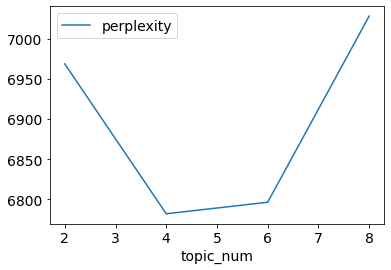

In [30]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

### 最佳的主題數為 4，也就是找 perplexity 較低 topic_num 也最少的

In [31]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, 
    id2word=id2word, # 字典
    num_topics=4, # 生成幾個主題數
    random_state=2021, # 亂數
    iterations = 1000,
    passes=5, # 模型訓練次數
)

In [32]:
ldaVis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
pyLDAvis.save_html(ldaVis,'./lda_result/ldaVis4.html')

/opt/homebrew/Caskroom/miniforge/base/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [33]:
IPython.display.HTML('./lda_result/ldaVis4.html')